In [1]:
from __future__ import print_function
import numpy as np

import keras
from keras.datasets import cifar10
from keras.layers import AveragePooling2D, Input, Flatten
from keras.layers import Dense, Conv2D, BatchNormalization, Activation
from keras.callbacks import ReduceLROnPlateau
from keras.regularizers import l2
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
from keras import backend as K
from keras.models import Model
import os

from sklearn.model_selection import train_test_split

Using TensorFlow backend.


Standard Augmentation

In [0]:
%matplotlib inline
import matplotlib.pyplot as plt

def transform(new_img, shift, dirctn):
    assert dirctn in ['right', 'left', 'down', 'up'], 'dirctns should be top|up|left|right'
    img = new_img.copy()
    
    if dirctn == 'right':
        right_slice = img[:,:shift].shape
        img[:, shift:] = img[:, :-shift]
        img[:,:shift] = np.zeros(right_slice)
            
    if dirctn == 'left':
        left_slice = img[:, -shift:].shape
        img[:, :-shift] = img[:, shift:]
        img[:, -shift:] = np.zeros(left_slice)
    if dirctn == 'down':
        down_slice = img[:shift, :].shape
        img[shift:, :] = img[:-shift,:]
        img[:shift, :] = np.zeros(down_slice)
    if dirctn == 'up':
        upper_slice = img[-shift:,:].shape
        img[:-shift, :] = img[shift:, :]
        img[-shift:,:] = np.zeros(upper_slice)
    
    return img


def std_aug():
  def augment(image_in, p=0.5):
    K = 4
    k1 = np.random.randint(-K, K)
    k2 = np.random.randint(-K, K)
    
    #img_h, img_w, img_c = image_in.shape
    p_1 = np.random.rand()
    if k1!=0 and k2!=0:
      if k1>0:
        image_in = transform(image_in, shift=abs(k1), dirctn='up')
      else:
        image_in = transform(image_in, shift=abs(k1), dirctn='down')

      if k2>0:
        image_in = transform(image_in, shift=abs(k2), dirctn='right')
      else:
        image_in = transform(image_in, shift=abs(k2), dirctn='left')

    if p_1 > p:
      image_in = np.fliplr(image_in)
    return image_in
  return augment




RESNET20

In [0]:


def resnet_layer(inputs,
                 num_filters=16,
                 kernel_size=3,
                 strides=1,
                 activation='relu',
                 batch_normalization=True,
                 conv_first=True):
    conv = Conv2D(num_filters,
                  kernel_size=kernel_size,
                  strides=strides,
                  padding='same',
                  kernel_initializer='he_normal',
                  kernel_regularizer=l2(1e-4))

 

    x = inputs
    if conv_first:
        x = conv(x)
        if batch_normalization:
            x = BatchNormalization()(x)
        if activation is not None:
            x = Activation(activation)(x)
    else:
        if batch_normalization:
            x = BatchNormalization()(x)
        if activation is not None:
            x = Activation(activation)(x)
        x = conv(x)
    return x


def resnet_v2(input_shape, depth, num_classes=10):
    
    if (depth - 2) % 9 != 0:
        raise ValueError('depth should be 9n+2 (eg 56 or 110 in [b])')
    # Start model definition.
    num_filters_in = 16
    num_res_blocks = int((depth - 2) / 9)

    inputs = Input(shape=input_shape)
    # v2 performs Conv2D with BN-ReLU on input before splitting into 2 paths
    x = resnet_layer(inputs=inputs,
                     num_filters=num_filters_in,
                     conv_first=True)

    # Instantiate the stack of residual units
    for stage in range(3):
        for res_block in range(num_res_blocks):
            activation = 'relu'
            batch_normalization = True
            strides = 1
            if stage == 0:
                num_filters_out = num_filters_in * 4
                if res_block == 0:  # first layer and first stage
                    activation = None
                    batch_normalization = False
            else:
                num_filters_out = num_filters_in * 2
                if res_block == 0:  # first layer but not first stage
                    strides = 2    # downsample

            # bottleneck residual unit
            y = resnet_layer(inputs=x,
                             num_filters=num_filters_in,
                             kernel_size=1,
                             strides=strides,
                             activation=activation,
                             batch_normalization=batch_normalization,
                             conv_first=False)
            y = resnet_layer(inputs=y,
                             num_filters=num_filters_in,
                             conv_first=False)
            y = resnet_layer(inputs=y,
                             num_filters=num_filters_out,
                             kernel_size=1,
                             conv_first=False)
            if res_block == 0:
                # linear projection residual shortcut connection to match
                # changed dims
                x = resnet_layer(inputs=x,
                                 num_filters=num_filters_out,
                                 kernel_size=1,
                                 strides=strides,
                                 activation=None,
                                 batch_normalization=False)
            x = keras.layers.add([x, y])

        num_filters_in = num_filters_out

    # Add classifier on top.
    # v2 has BN-ReLU before Pooling
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = AveragePooling2D(pool_size=8)(x)
    y = Flatten()(x)
    outputs = Dense(num_classes,
                    activation='softmax',
                    kernel_initializer='he_normal')(y)

    # Instantiate model.
    model = Model(inputs=inputs, outputs=outputs)
    return model


Data Preparation

In [4]:

(x_train, y_train), (x_test, y_test) = cifar10.load_data()

input_shape = x_train.shape[1:]

x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255

x_train, X_test, y_train, Y_test = train_test_split(x_train, y_train, stratify=y_train, test_size=0.8)

N = 10

y_train = keras.utils.to_categorical(y_train, N)
y_test = keras.utils.to_categorical(y_test, N)


170500096/170498071 [==============================] - 4s 0us/step


Training Parameters

In [0]:
batch_size = 128 
epochs = 100
#N = 10

n=3
depth = n*6+2
model_type = 'ResNet%dv' % (depth)

Model


In [6]:
model = resnet_v2(input_shape=input_shape, depth=depth)


model.compile(loss='categorical_crossentropy',
              optimizer=Adam(learning_rate=0.001),
              metrics=['accuracy'])

datagen = ImageDataGenerator(
        preprocessing_function=std_aug())

datagen.fit(x_train)

plot = model.fit_generator(datagen.flow(x_train, y_train, batch_size=batch_size),
                    validation_data=(x_test, y_test),
                    epochs=epochs, verbose=1, workers=4)
             
#Final Scores             
scores = model.evaluate(x_test, y_test, verbose=1)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])

Epoch 1/100
79/79 [==============================] - 17s 219ms/step - loss: 2.2740 - accuracy: 0.3203 - val_loss: 3.1233 - val_accuracy: 0.1742
Epoch 2/100
79/79 [==============================] - 7s 87ms/step - loss: 1.9775 - accuracy: 0.4272 - val_loss: 2.7820 - val_accuracy: 0.2581
Epoch 3/100
79/79 [==============================] - 7s 86ms/step - loss: 1.8091 - accuracy: 0.4826 - val_loss: 2.2418 - val_accuracy: 0.3545
Epoch 4/100
79/79 [==============================] - 7s 86ms/step - loss: 1.7096 - accuracy: 0.5131 - val_loss: 2.0098 - val_accuracy: 0.4318
Epoch 5/100
79/79 [==============================] - 7s 86ms/step - loss: 1.6196 - accuracy: 0.5446 - val_loss: 1.9025 - val_accuracy: 0.4728
Epoch 6/100
79/79 [==============================] - 7s 86ms/step - loss: 1.5515 - accuracy: 0.5644 - val_loss: 1.8113 - val_accuracy: 0.4805
Epoch 7/100
79/79 [==============================] - 7s 87ms/step - loss: 1.4967 - accuracy: 0.5892 - val_loss: 1.8959 - val_accuracy: 0.4933
Epoc

Plot : Accuracy

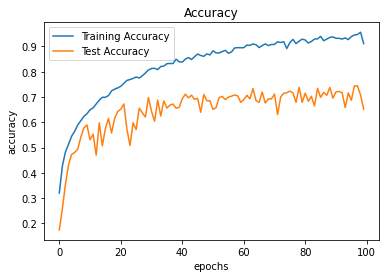

In [7]:
import matplotlib.pyplot as plt

plt.figure(0)
plt.plot(plot.history['accuracy'], label='Training Accuracy')
plt.plot(plot.history['val_accuracy'], label='Test Accuracy')
plt.title('Accuracy')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend()

Plot : Loss

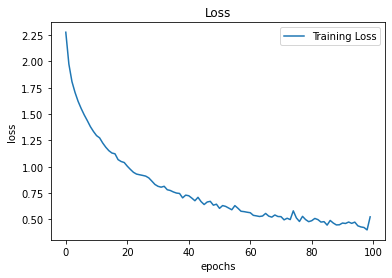

In [8]:
plt.plot(plot.history['loss'], label='Training Loss')
plt.title('Loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()